# Terphenyl Heteropolymer Analysis Notebook

In this notebook I will perform several data analysis on the RHH terphenyl octamer. This molecule has 3 aromatic moieties connected with peptide-linkers. Collaborators in the Gellman group, at U Wisc-Ma., have been trying to synthesize and characterize this molecule. This would represent a novel type of foldamer molecule.

## Replica Exchange Energy Distributions

For replica exchange data, it is imporant to see the overlap of energy states from each replica. For this reason we will look at the histogram of energies from each simulation and confirm that energies each replica is behaving as expected.

In [72]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import panedr
import matplotlib.pyplot as plt
import numpy as np
import os
import pymbar
import analysis_library
from scipy.constants import physical_constants, find

plt.style.use('ggplot')

In [ ]:
energy_df = panedr.edr_to_df("/mnt/summit/RHH/remd_sim/sim0/npt.edr")
energy_df.head()

In [ ]:
energy_df.keys()

In [ ]:
# Extract Potential Energies from each simulation
sim_dir_name = "sim"
path = "/mnt/summit/RHH/remd_sim/"
n_replicas = 20

energies, temps = analysis_library.get_energies(sim_dir_name, path, n_replicas)

In [ ]:
plt.figure(figsize=[8,4], dpi=600)
for i in range(len(temps)):
    # requires cutting off outlier (likely initial frame)
    plt.hist(energies[i][energies[i] > np.min(energies[i])], bins = 50, alpha = 0.6)
    plt.xlabel("Enthalpy")
    plt.ylabel("Counts")
# plt.legend([str(np.round(t, 1)) for t in temps])

In [ ]:
for i in range(len(temps) - 1):
    print("Delta beta:", 1/np.array(temps[i]) - 1/np.array(temps[i + 1]))

## Heat Capacity Curve

The nice thing about replica exchange simulations is we can compute the change of a systems heat capacity with temperature.This is especially useful for systems that experience large surface area changes during phase transistions, such as protein folding or melting transitions.

We'll be implementing heat capacity equation, using enthalpy:

$$C_p = \frac{d<H>}{dT}$$

We'll be calculating expectation heat capacities using the following formulas:



In [ ]:
u_kln, n_samples = analysis_library.construct_u_kln_matrix(temps, energies, add_temps = np.linspace(230, 325, 200))

In [ ]:
energies

In [ ]:
# MBAR
mbar = pymbar.MBAR(u_kln, n_samples, verbose = True, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)

In [ ]:
# Building potential energy kln matrix
E_kln = u_kln
for k in range(K_all):
    E_kln[:,k,:] *= betas[k]**(-1)

# mean and variance of energy
results = mbar.computeExpectations(E_kln, state_dependent=True, return_dict=True)
E_expected = results['mu']
dE_exoected = results['sigma']

In [68]:
# mean and variance of difference of energies
results = mbar.computeExpectations(E_kln, output='differences', state_dependent=True, return_dict=True)
DeltaE_expected = results['mu']
dDeltaE_expected = results['sigma']

A squared uncertainty is negative. Largest Magnitude = 0.000011


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


In [69]:
# mean and variance of energies squared
results = mbar.computeExpectations(E_kln**2, state_dependent=True, return_dict=True)
E2_expected = results['mu']
dE2_expected = results['sigma']

In [70]:
Cp_expect = (E2_expected - (E_expected*E_expected)) / (kb * t_list**2)

Text(0.5, 0, 'Temperature (K)')

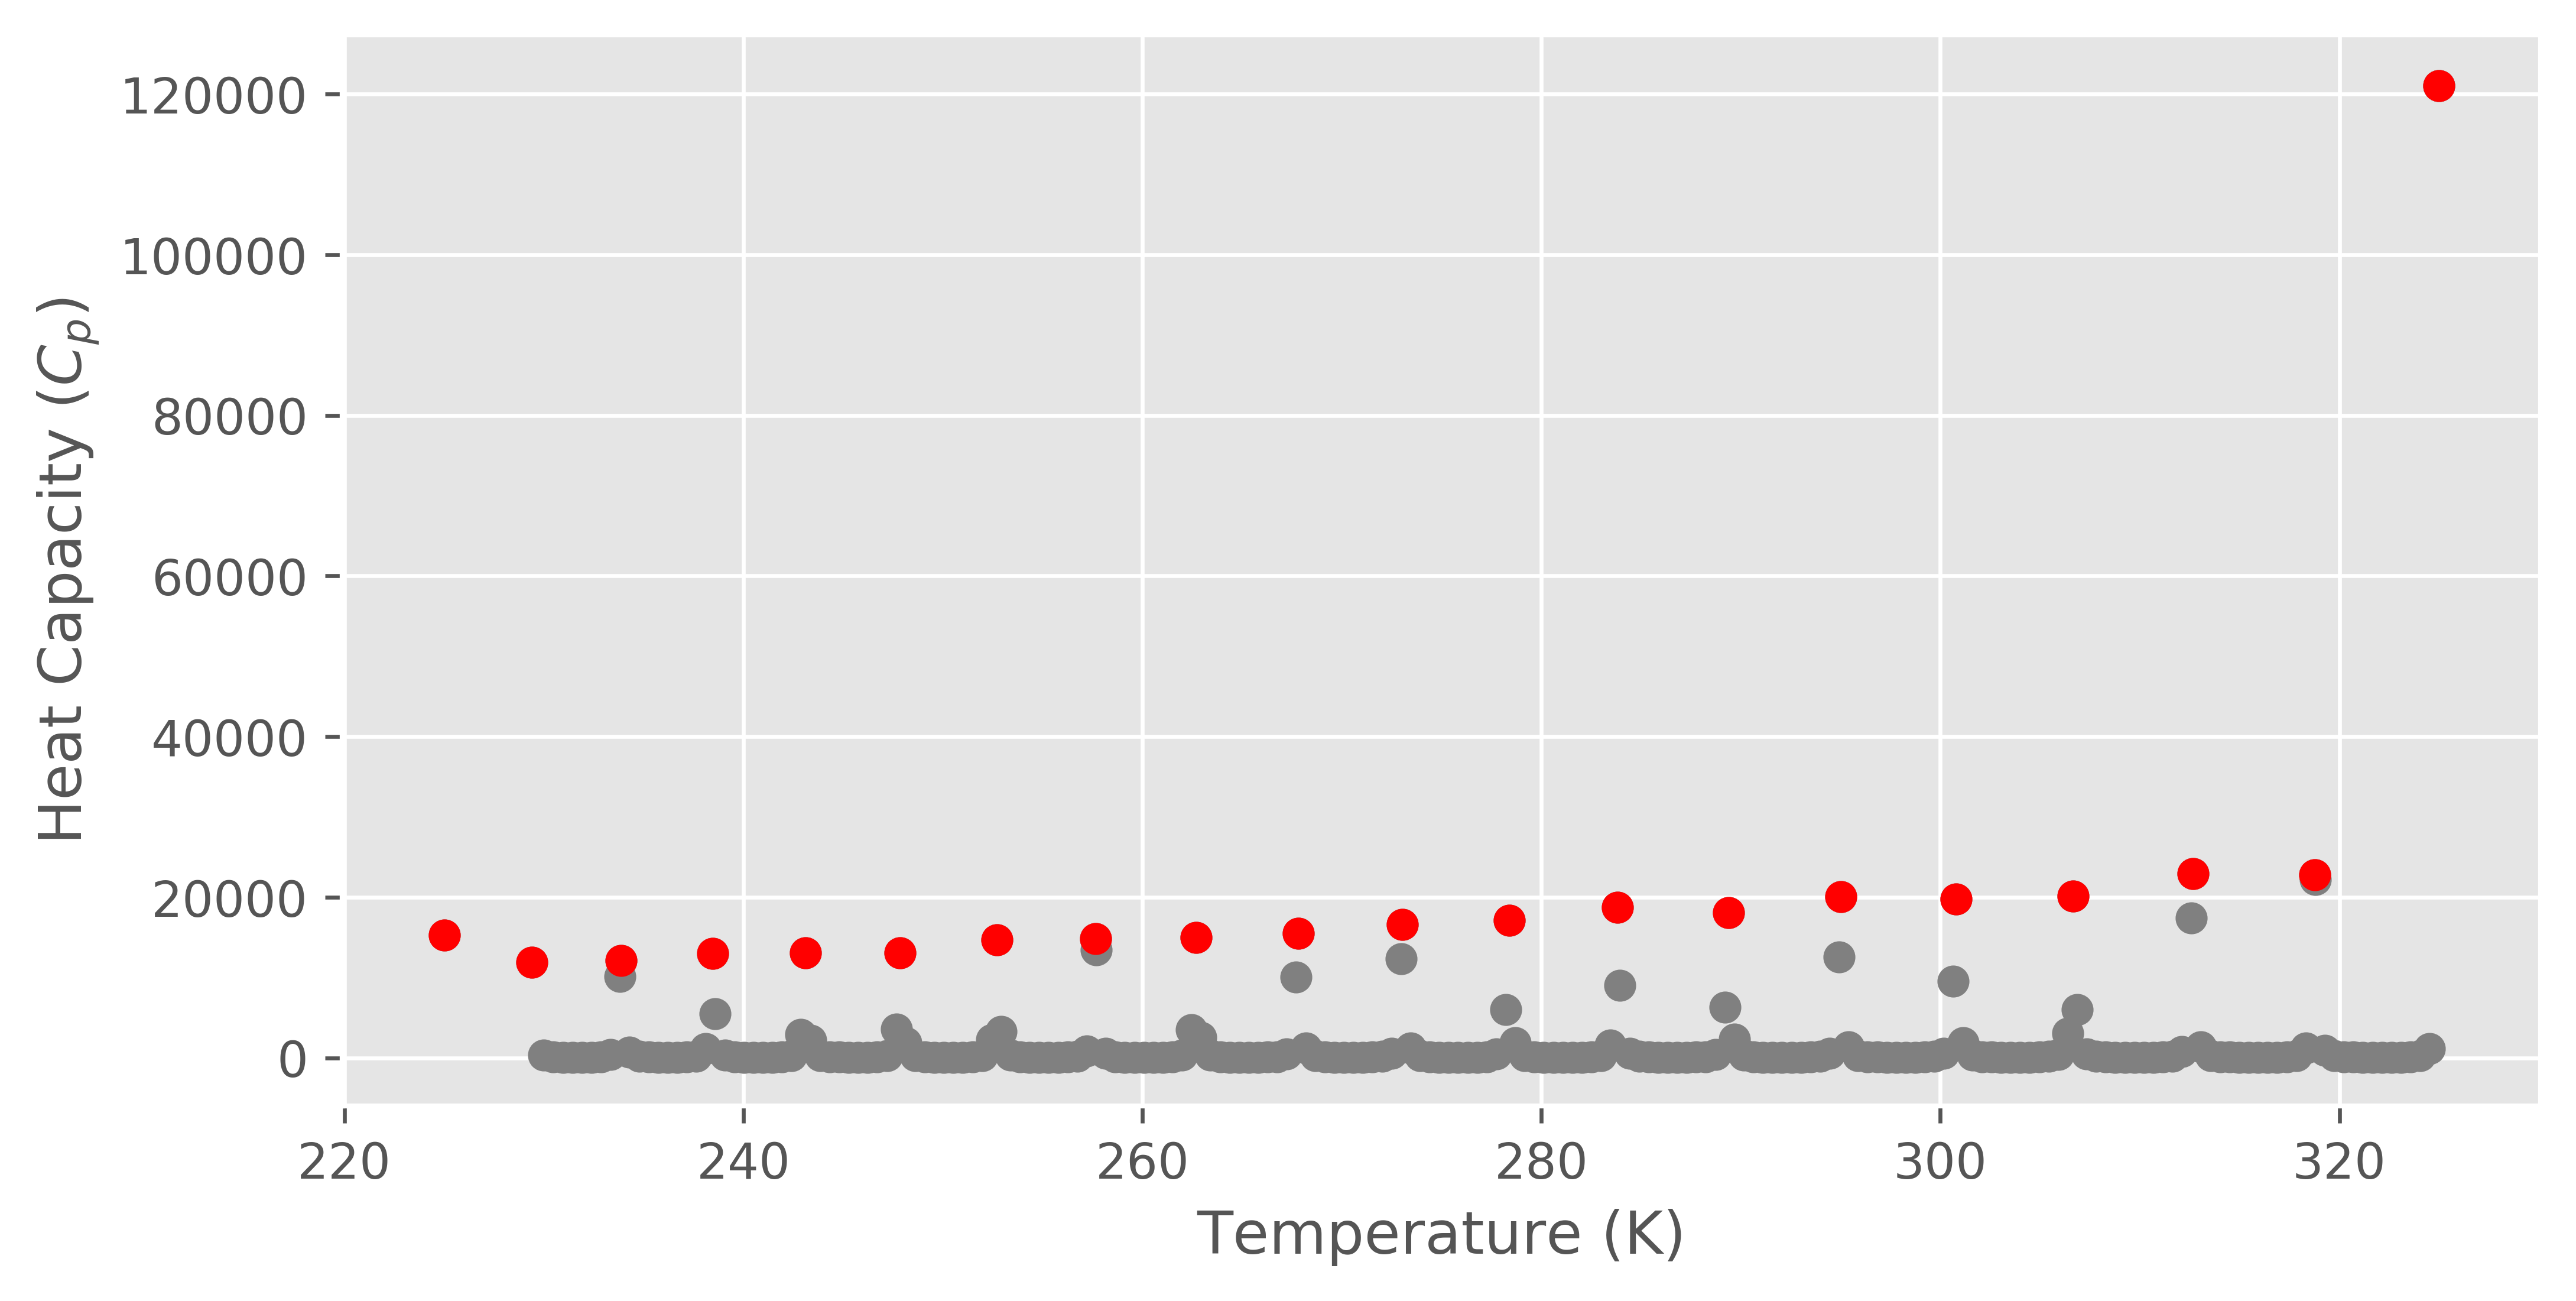

In [71]:
plt.figure(figsize=[8,4], dpi=600)
plt.scatter(t_list, Cp_expect, color = "gray")
plt.scatter(t_list[:20], Cp_expect[:20], color = "red")
plt.ylabel("Heat Capacity ($C_p$)")
plt.xlabel("Temperature (K)")